In [1]:
# load packages
from google.colab import drive, files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import regex as re
import seaborn as sns
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DS4A-Project/Data/political_news/'

Mounted at /content/drive


In [ ]:
image_output_path = '/content/drive/My Drive/DS4A-Project/Code/images/'

In [4]:
# read in raw datasets
df_fake = pd.read_csv(path + 'Fake.csv')
df_real = pd.read_csv(path + 'True.csv')

In [ ]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_fake.at[4,"text"][-100:]

'om their land, leave behind their dear ones. Amen to that.Photo by Christopher Furlong/Getty Images.'

In [ ]:
df_fake.at[100,"text"][-100:]

'd not accept the nomination if it was given to him right now.Photo by Chip Somodevilla/Getty Images.'

In [5]:
# create indicator for fake news
df_fake['fake_flag'] = 1
df_real['fake_flag'] = 0

Raw Data EDA

In [ ]:
# combine data
df_raw = pd.concat([df_fake, df_real])

In [ ]:
df_raw

,title,text,subject,date,fake_flag,text_length
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,2893
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,1898
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,3597
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,2774
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,2346
...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0,2821
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0,800
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0,1950
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0,1199


In [ ]:
# TEXT_COLUMN = 'title'
TEXT_COLUMN = 'text'
text_fake = df_fake[TEXT_COLUMN]
text_real = df_real[TEXT_COLUMN]

Data composition

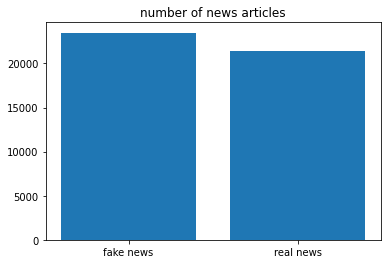

number of fake articles:  23481
number of real articles:  21417


In [ ]:
# number of fake and real data
n_fake = df_fake.shape[0]
n_real = df_real.shape[0]
plt.bar(x = [0,1], height = [n_fake, n_real], tick_label = ['fake news', 'real news'])
plt.title("number of news articles")
plt.savefig(f"{image_output_path}/num_news_articles.jpg") 
plt.show()
print("number of fake articles: ", n_fake)
print("number of real articles: ", n_real)

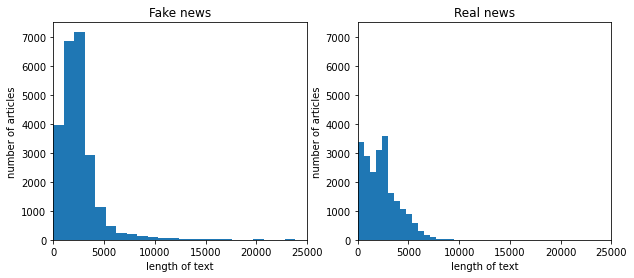

median length of fake news articles : 2166.0
median length of real news articles : 2222.0
standard deviation of length of fake news articles : 2532.8843992489196
standard deviation of length of real news articles : 1684.8357303747152


In [ ]:
# Q: Is there a significant difference in length between the real and fake news? 
# We can redo this analysis with number of words 
df_fake["text_length"] = df_fake["text"].apply(lambda x: len(x))
df_real["text_length"] = df_real["text"].apply(lambda x: len(x))

fig, axes = plt.subplots(ncols = 2, figsize = (10, 4))
axes[0].hist(df_fake["text_length"], bins = 50)
axes[0].set_title("Fake news")
axes[1].hist(df_real["text_length"], bins = 50)
axes[1].set_title("Real news")
for ax in axes.ravel(): 
  ax.set_ylim(0, 7500)
  ax.set_xlim(0, 25000)
  ax.set_xlabel('length of text')
  ax.set_ylabel('number of articles')
plt.savefig(f"{image_output_path}/text_length.jpg")
plt.show()

print("median length of fake news articles :", df_fake["text_length"].median())
print("median length of real news articles :", df_real["text_length"].median())
print("standard deviation of length of fake news articles :", df_fake["text_length"].std())
print("standard deviation of length of real news articles :", df_real["text_length"].std())

Real and fake news have similar median length. However, fake news has higher variability in news length.  

Top Non-Stopwords

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    # exclude '[video]', '(video)', and 'watch:' as these appear in
    # the list of top non-stopwords for fake news titles
    stop.add('[video]')
    stop.add('(video)')
    stop.add('watch:')
    stop.add('(Reuters)')
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word.lower() for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # plt.figure(figsize=(8,6))
    # plt.title('Top Non-Stopwords')
    sns.barplot(x=y, y=x)

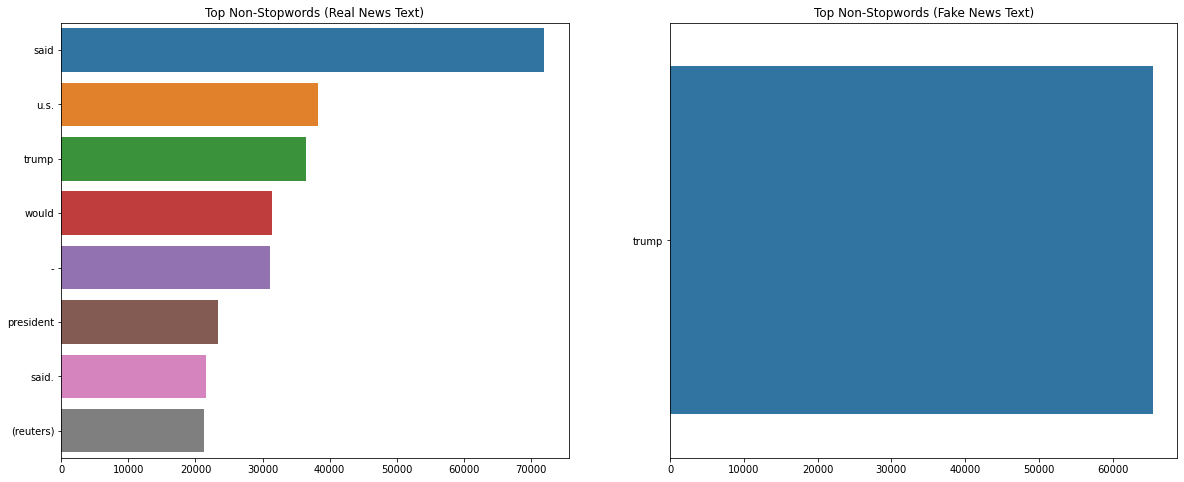

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Top Non-Stopwords (Real News Text)')
plot_top_non_stopwords_barchart(text_real)
plt.subplot(1, 2, 2)
plt.title('Top Non-Stopwords (Fake News Text)')
plot_top_non_stopwords_barchart(text_fake)
plt.savefig(f"{image_output_path}/top_nonstopwords_text.jpg")

Top N-grams

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word.lower() for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(text, n)[:10]
    x,y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Bigrams

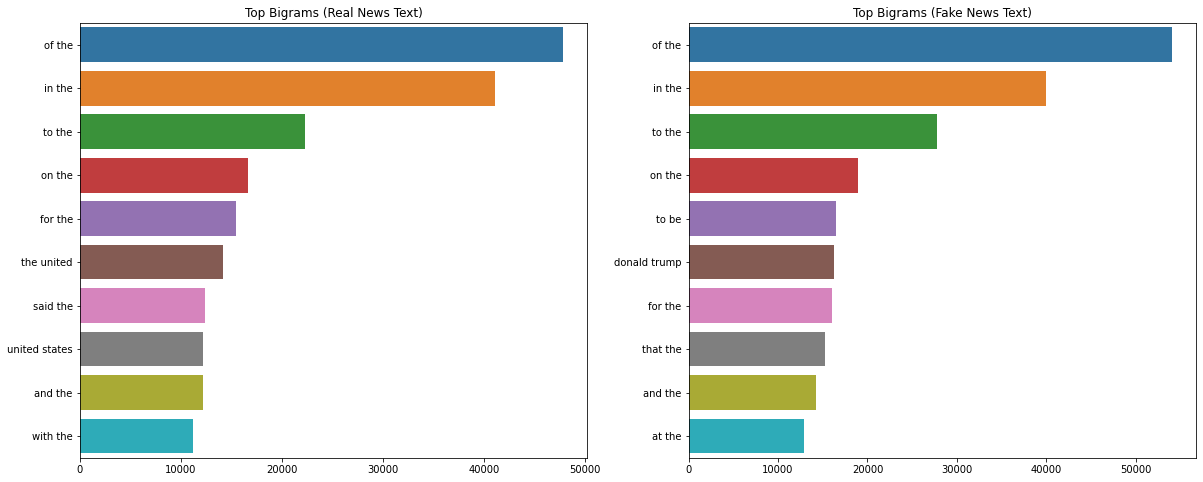

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Top Bigrams (Real News Text)')
plot_top_ngrams_barchart(text_real, 2)
plt.subplot(1, 2, 2)
plt.title('Top Bigrams (Fake News Text)')
plot_top_ngrams_barchart(text_fake, 2)
plt.savefig(f"{image_output_path}/top_bigrams_text.jpg")

Trigrams

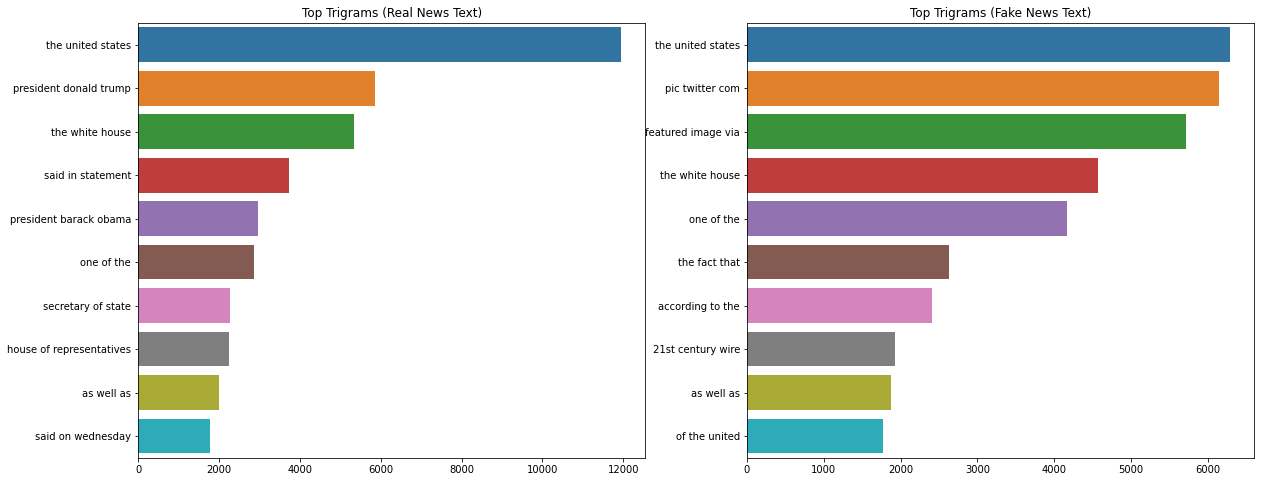

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Top Trigrams (Real News Text)')
plot_top_ngrams_barchart(text_real, 3)
plt.subplot(1, 2, 2)
plt.title('Top Trigrams (Fake News Text)')
plot_top_ngrams_barchart(text_fake, 3)
plt.savefig(f"{image_output_path}/top_trigrams_text.jpg")

Wordclouds

In [ ]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w) > 2]

            corpus.append(words)
        return corpus
    
    corpus = _preprocess_text(text)
    
    wordcloud = WordCloud(
                background_color='white',
                stopwords=set(STOPWORDS),
                max_words=100,
                max_font_size=30, 
                scale=3,
                random_state=1)
    
    wordcloud = wordcloud.generate(str(corpus))

    # fig = plt.figure(1, figsize=(12,12))
    # plt.axis('off')
 
    # plt.imshow(wordcloud)
    # plt.show()

    return wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


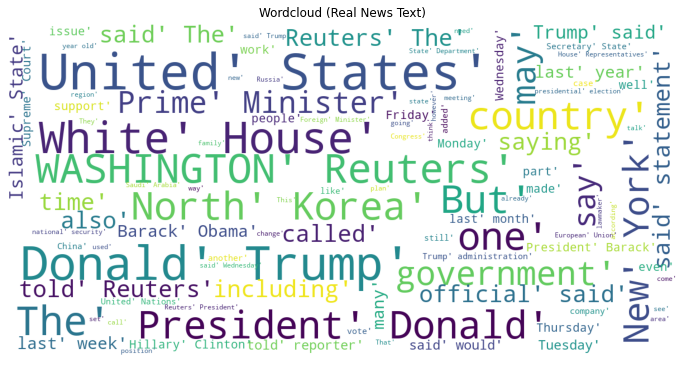

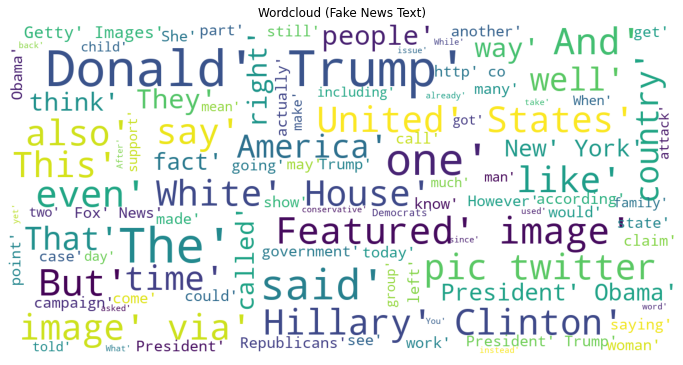

In [ ]:
plt.figure(figsize=(12,12))
# plt.subplot(1, 2, 1)
plt.title('Wordcloud (Real News Text)')
plt.axis('off')
plt.imshow(plot_wordcloud(text_real))
plt.savefig(f"{image_output_path}/wordcloud_real_text.jpg")
plt.figure(figsize=(12,12))
# plt.subplot(1, 2, 2)
plt.title('Wordcloud (Fake News Text)')
plt.axis('off')
plt.imshow(plot_wordcloud(text_fake))
plt.savefig(f"{image_output_path}/wordcloud_fake_text.jpg")

Preprocessing ( In progress)

In [ ]:
import random

In [ ]:
# random fake & real articles
print("Example fake articles: ")
fake_idx = random.sample(range(df_fake.shape[0]),5)
for idx in fake_idx:
  print(df_fake.at[idx,"text"])

print("\nExample real articles: ")
real_idx = random.sample(range(df_real.shape[0]),5)
for idx in real_idx:
  print(df_real.at[idx,"text"])

Example fake articles: 
On Friday, Donald Trump decided to distract from revelations that intelligence agencies had identified the individual Russians who delivered hacked documents to Wikileaks on behalf of The Donald s  best friend  Vladimir Putin by proving to the world that what he lacks in his desire to attend intelligence briefings he makes up for in his adherence to the principle that  ratings aree everything. Wow, the ratings are in and Arnold Schwarzenegger got  swamped  (or destroyed) by comparison to the ratings machine, DJT. So much for .  Trump tweeted. Nine minutes later, he added,  being a movie star-and that was season 1 compared to season 14. Now compare him to my season 1. But who cares, he supported Kasich & Hillary. Wow, the ratings are in and Arnold Schwarzenegger got "swamped" (or destroyed) by comparison to the ratings machine, DJT. So much for .  Donald J. Trump (@realDonaldTrump) January 6, 2017Wow, the ratings are in and Arnold Schwarzenegger got "swamped" (or

Some differences between the fake and real news articles:  
  * fake news articles do not contain apostrophes, whereas real news articles contain apostrophes: ex) fake: "don t", real: "don't".  
    * We should replace apostrophes in the real articles with a space
  * real news articles contain the source in the beginning, while fake news articles contain the source at the end.  
    * This is important to address, since we don't want our model just looking at the beginning and end of text to look for news source. 
    * We can remove the source at the beginning of real news articles using regex. 
    * I removed the source at the end of the fake news by removing string appearing after the last period. This generally works, but there are still some fake news articles that contain the source. 


Text processing performed on both fake and real news articles:  
* replace any URL with word URL  
* remove twitter handles ex) @realDonaldTrump, hashtags
* remove punctuation, numbers, extra spaces
* lowercase  
* remove stop words?
* stemming / lemmatizing? : These may be required before doing tf-idf. However, we may want to keep the words as is when using RNN / LSTM / BERT type models, since these models can pick up on tone and nuances of writing.  
* combine title and text


In [ ]:
def cleanText(text):

  # add apostrophes
  text = re.sub(" s ", "\u2019s ", text)
  text = re.sub(" t ", "\u2019t ", text)
  text = re.sub(" ve ", "\u2019ve ", text)
  text = re.sub(" ll ", "\u2019ll ", text)
  text = re.sub(" m ", "\u2019m ", text)
  # replace any url with string "URL"
  text = re.sub(r"http\S+","URL", text)

  # remove twitter handles
  text = re.sub('@[^\s]+','',text)

  # remove hashtags
  text = re.sub('#[^\s]+','',text)

  # remove punctuation / symbols / numbers
  pattern = r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)

  # replace multiple spaces with single space
  text = re.sub(" +", " ", text)

  # make lowercase 
  words = text.split()
  words = [item.lower() for item in words]

  # remove stopwords
  stop = set(stopwords.words('english'))
  words = [w for w in words if w not in stop]

  # stem or lemmatize
  # porter = PorterStemmer()
  # words = [porter.stem(item) for item in words]
  #lem = WordNetLemmatizer()
  #words = [lem.lemmatize(item) for item in words]

  return words

In [19]:
# remove last two sentences 
def remove_last_two(text):
  text = re.sub('[.?!][^?|.|!]*$','',text)
  text = re.sub('[.?!][^?|.|!]*$','',text)
  text = re.sub('[.?!][^?|.|!]*$','',text)
  text = text +"."
  return text

In [ ]:
# for fake news only
# (remove the string after the last punctuation marks (.!?) ) * 2 This will generally remove the source of the fake news
df_fake["text_cleaned"] = df_fake["text"].apply(lambda x: re.sub('@21WIRE.TV', '',x))
df_fake["text_cleaned"] = df_fake["text_cleaned"].apply(remove_last_two)

# apply cleanText
df_fake["title_cleaned"] = df_fake["title"].apply(cleanText)
df_fake["text_cleaned"] = df_fake["text_cleaned"].apply(cleanText)

# For real news only
# remove the WSHINGTON (Reuters) type string at the beginning
df_real["text_cleaned"] = df_real["text"].apply(lambda x: re.sub("^[^-]*- ", "",x))
# remove some of the source at the end
df_real["text_cleaned"] = df_real["text_cleaned"].apply(lambda x:re.sub(" -- Source link: .*","",x))
df_real["text_cleaned"] = df_real["text_cleaned"].apply(remove_last_two)

# apply cleanText
df_real["text_cleaned"] = df_real["text_cleaned"].apply(cleanText)
df_real["title_cleaned"] = df_real["title"].apply(cleanText)

In [ ]:
df_fake.head()

,title,text,subject,date,fake_flag,text_cleaned,title_cleaned
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, couldnt, wish, americans, happ...","[donald, trump, sends, embarrassing, new, year..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,"[friday, revealed, former, milwaukee, sheriff,...","[sheriff, david, clarke, becomes, internet, jo..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,"[christmas, day, donald, trump, announced, wou...","[trump, obsessed, even, obamas, name, coded, w..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,"[pope, francis, used, annual, christmas, day, ...","[pope, francis, called, donald, trump, christm..."


In [ ]:
# combine fake & real
df = pd.concat([df_fake, df_real])

# combine cleaned title & text
df["title_text_cleaned"] = df["title_cleaned"] + df["text_cleaned"] 

In [ ]:
# add stemmed version 
porter = PorterStemmer()
df["title_text_stemmed"] = df["title_text_cleaned"].apply(lambda x: [porter.stem(item) for item in x])

In [ ]:
df.drop(columns = ["title","text"], inplace = True)
df.drop(columns = ["text_cleaned", "title_cleaned"], inplace = True)
df.drop(columns = ["date"], inplace = True)

In [ ]:
df.head()

,subject,fake_flag,title_text_cleaned,title_text_stemmed
0,News,1,"[donald, trump, sends, embarrassing, new, year...","[donald, trump, send, embarrass, new, year, ev..."
1,News,1,"[drunk, bragging, trump, staffer, started, rus...","[drunk, brag, trump, staffer, start, russian, ..."
2,News,1,"[sheriff, david, clarke, becomes, internet, jo...","[sheriff, david, clark, becom, internet, joke,..."
3,News,1,"[trump, obsessed, even, obamas, name, coded, w...","[trump, obsess, even, obama, name, code, websi..."
4,News,1,"[pope, francis, called, donald, trump, christm...","[pope, franci, call, donald, trump, christma, ..."


In [ ]:
df.to_csv('/content/drive/My Drive/DS4A-Project/Data/political_news/cleaned_data2.csv', index = False)

## Data cleaning for BERT
* Need much less preprocessing, since BERT has its own tokenizer.  
* Just some cleaning to remove biases in the different sets


In [ ]:
#import transformers
#from transformers import BertTokenizerFast
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# to test tokenizer
#tokenizer.tokenize(string)

In [ ]:
def cleanText_BERT(text):
  # USED FOR TRAINING BERT

  # add aposrophes
  text = re.sub(" s ", "\u2019s ", text)
  text = re.sub(" t ", "\u2019t ", text)
  text = re.sub(" ve ", "\u2019ve ", text)
  text = re.sub(" ll ", "\u2019ll ", text)
  text = re.sub(" m ", "\u2019m ", text)

  # remove twitter handles
  text = re.sub('@[^\s]+','',text)

  # remove hashtags
  text = re.sub('#[^\s]+','',text)

  # replace multiple spaces with single space
  text = re.sub(" +", " ", text)

  # convert U.S. to US
  text = re.sub("U.S.", "US", text)
  return text

In [17]:
def cleanText_BERT2(text):
  # USED FOR LIME
  # same as cleanText + remove stopwords 

  # remove parenthesis
  text = re.sub("\("," ",text)
  text = re.sub("\)"," ",text)

  # add aposrophes
  text = re.sub(" s ", "\u2019s ", text)
  text = re.sub(" t ", "\u2019t ", text)
  text = re.sub(" ve ", "\u2019ve ", text)
  text = re.sub(" ll ", "\u2019ll ", text)
  text = re.sub(" m ", "\u2019m ", text)

  # remove twitter handles
  text = re.sub('@[^\s]+','',text)

  # remove hashtags
  text = re.sub('#[^\s]+','',text)

  # replace multiple spaces with single space
  text = re.sub(" +", " ", text)

  # convert U.S. to US
  text = re.sub("U.S.", "US", text)

  # make lowercase 
  words = text.split()

  # remove stopwords
  stop = set(stopwords.words('english'))
  words = [w for w in words if w.lower() not in stop]

  text = ' '.join(words)

  return text

In [20]:
# for fake news text
# remove the string after the last punctuation marks (.!?) This will generally remove the source of the fake news
df_fake["text_BERT"] = df_fake["text"].apply(lambda x: re.sub('@21WIRE.TV', '',x))
df_fake["text_BERT"] = df_fake["text_BERT"].apply(remove_last_two)
df_fake["text_BERT"] = df_fake["text_BERT"].apply(cleanText_BERT2)

# fake news title
df_fake["title_BERT"] = df_fake["title"].apply(cleanText_BERT2)
# add period at end of title. 
df_fake["title_BERT"] = df_fake["title_BERT"].apply(lambda x: x +". ")


# For real news text
# remove the WASHINGTON (Reuters) type string at the beginning
df_real["text_BERT"] = df_real["text"].apply(lambda x: re.sub("^[^-]*- ", "",x))
# remove some of the source at the end 
df_real["text_BERT"] = df_real["text_BERT"].apply(lambda x:re.sub(" -- Source link: .*","",x))
df_real["text_BERT"] = df_real["text_BERT"].apply(remove_last_two)

# apply cleanText
df_real["text_BERT"] = df_real["text_BERT"].apply(cleanText_BERT2)

#real news title
df_real["title_BERT"] = df_real["title"].apply(cleanText_BERT2)
# add period at end of title. 
df_real["title_BERT"] = df_real["title_BERT"].apply(lambda x: x +". ")

In [23]:
# random fake & real articles
print("Example fake articles: ")
fake_idx = random.sample(range(df_fake.shape[0]),5)
for idx in fake_idx:
  print(df_fake.at[idx,"text_BERT"])

print("\nExample real articles: ")
real_idx = random.sample(range(df_real.shape[0]),5)
for idx in real_idx:
  print(df_real.at[idx,"text_BERT"])

Example fake articles: 
21st Century Wire says Nevada Assemblywoman Michele Fiore reports Newsmax TV Las Vegas, ongoing federal trial involving rancher Cliven Bundy family. video report, Fiore claims new inside information regarding federal criminal case continues extended federal authorities, Bundy family held federal custody 18 months now.According Fiore, FBI actually evidence prosecute Bundys based raft inflated charges piled original federal complaint here: 298981770-Criminal-Complaint-re-Cliven-Bundy-pdf , relying solely pressuring fringe actors case also custody, order might testify Bundys.If Fiore’s claims true, could mean good news family. Meanwhile, public must wait see happen next.
days experiencing leadership skills Kellyanne Conway, Donald Trump’s new campaign manager, offer, far it’s disaster. interview CNN’s State Union gave us taste Conway’s ability handle little bit grilling press.Before rise top, Conway called Trump refusal release tax returns. Dana Bash, show’s host, 

In [35]:
# combine fake & real
df = pd.concat([df_fake, df_real])

# combine cleaned title & text
df["title_text_BERT"] = df["title_BERT"] + df["text_BERT"] 
df.reset_index(drop = True, inplace = True )

In [36]:
df.drop(columns = ["title","text", "date", "text_BERT","title_BERT"], inplace = True)

In [37]:
df.head()

,subject,fake_flag,title_text_BERT
0,News,1,Donald Trump Sends Embarrassing New Year’s Eve...
1,News,1,Drunk Bragging Trump Staffer Started Russian C...
2,News,1,Sheriff David Clarke Becomes Internet Joke Thr...
3,News,1,Trump Obsessed Even Obama’s Name Coded Website...
4,News,1,Pope Francis Called Donald Trump Christmas Spe...


In [43]:
# random articles
print("Example articles: ")
random_idx = random.sample(range(df.shape[0]),5)
for idx in random_idx:
  print(df.at[idx,"title_text_BERT"])

Example articles: 
Trump take handful executive actions Day One: transition. President-elect Donald Trump may take four five executive actions Friday, day sworn office, spokesman Sean Spicer said. “He’s got probably area four five we’re looking Friday,” logistical, Spicer said Wednesday news briefing. “Then ones expect sign respect couple issues high priority list.
Reporter Calls Racist Writer Trump Invited Press Briefing – Press Room Erupts Chaos. may work Fox Radio man deserves ton respect did. breaking point Trump’s love affair racist blog Gateway Pundit, Fox Radio’s Jon Decker openly vehemently criticized White House allowing website, panders fake right-wing conspiracies racist rhetoric, attend daily press briefings alongside legitimate news sources.Decker didn’t hold back. Pointing directly Gateway Pundit’s Lucian Wintrich, Decker noted site hate blacks, Jews, [and] Hispanics don’t deserve room. moment reporter finally enough Trump’s normalization racism, white Nationalism, xenoph

In [51]:
df.to_csv('/content/drive/My Drive/DS4A-Project/Data/political_news/BERT_LIME_data.csv', index = False)

# More EDA with cleaned data

In [ ]:
# Where did many of the fake news data come from?

# look at the source at the end

In [ ]:
df_fake.at[999,"text"]

"Donald Trump s war on the free press just entered a dark new phase. After spending the election smearing reporters, sometimes personally, his administration has only gotten worse once in power. Trump continues to attack any media that dares criticize him, and his staff have begun cancelling press briefings and blocking recording devices in the White House. On Tuesday, Deputy Press Secretary Sarah Huckabee attended the first on-camera press briefing in over a week   only to begin a disgustingly, dishonest smear of the free press.People watching in horror as Trump and his team undermine the media s ability to have a check on their power have been begging reporters to stand up for themselves and their duties   and one finally did.In a powerful moment, Brian Karem of The Sentinel, couldn t take it anymore. Standing up, he cut Huckabee off and said what has been on everybody s mind: Come on! You re inflaming everybody, right here, right now with those words. This administration has done th

## TF-IDF

In [ ]:
import ast
import scipy.sparse
from random import sample
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

In [ ]:
df = pd.read_csv(path + "cleaned_data.csv")
# convert string representation of list to list
df["title_text_cleaned"] = df["title_text_cleaned"].apply(lambda x: ast.literal_eval(x))
df["title_text_stemmed"] = df["title_text_stemmed"].apply(lambda x: ast.literal_eval(x))

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer()

corpus = df["title_text_stemmed"].apply(lambda x: ' '.join(x))
corpus = corpus.tolist()

X = vectorizer.fit_transform(corpus)

In [ ]:
# save tfidf 
scipy.sparse.save_npz(path +'tfidf.npz', X)
# to open: sparse_matrix = scipy.sparse.load_npz(filepath)

In [ ]:
X.shape

(44898, 167152)

Visualize 1000 random samples via PCA



In [ ]:
sampled_idx = sample(range(n_doc), 700)
X_sampled = X[sampled_idx,:]

n_fake = df_fake.shape[0]
fake_idx = [i for i in range(700) if sampled_idx[i] < n_fake]
real_idx = [i for i in range(700) if sampled_idx[i] >= n_fake]

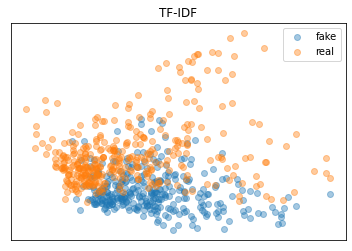

In [ ]:
# pca
embedding = PCA(n_components = 2)
X_transformed = embedding.fit_transform(X_sampled.toarray())


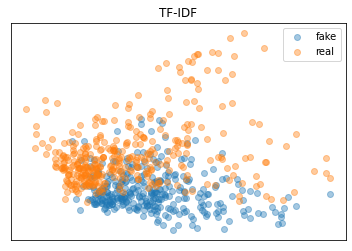

In [ ]:
plt.scatter(X_transformed[fake_idx,0], X_transformed[fake_idx,1], alpha = 0.4, label = 'fake')
plt.scatter(X_transformed[real_idx,0], X_transformed[real_idx,1], alpha = 0.4, label = 'real')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title("TF-IDF")
plt.show()


## Documet embedding via doc2vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
df_BERT = pd.read_csv(path + "BERT_data.csv")
df_fake = pd.read_csv(path + "Fake.csv")
n_fake = df_fake.shape[0]

In [ ]:
# prepare text for Doc2Vec
total_text = df_BERT["title_text_BERT"].apply(lambda x: [item.lower() for item in x.split()])
total_doc = [TaggedDocument(doc, [i]) for i, doc in enumerate(total_text)]

In [ ]:
# train model
#model = Doc2Vec(vector_size=300, dm = 1, window=10, min_count=3, epochs =50)
#model.build_vocab(total_doc)
#model.train(total_doc, total_examples=model.corpus_count, epochs=model.epochs)
#model.save(path + 'doc2vec.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# load trained model
model = Doc2Vec.load(path + 'doc2vec.model') 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
sampled_idx = sample(range(n_doc), 700)
X_sampled = X[sampled_idx,:]

n_fake = df_fake.shape[0]
fake_idx = [i for i in range(700) if sampled_idx[i] < n_fake]
real_idx = [i for i in range(700) if sampled_idx[i] >= n_fake]

In [ ]:
# get sample doc embedding
doc_embedding = np.zeros((700, 300))
for idx, i in enumerate(sampled_idx):
  doc_embedding[idx,:] = model.infer_vector(total_text[i])
  #doc_embedding[i,:] = model.docvecs[1000]

In [ ]:
# pca
pca = PCA(n_components = 2)
X_transformed = pca.fit_transform(doc_embedding)

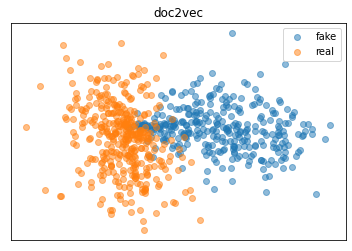

In [ ]:
plt.scatter(X_transformed[fake_idx,0],X_transformed[fake_idx,1], label ="fake", alpha = 0.5)
plt.scatter(X_transformed[real_idx,0], X_transformed[real_idx,1], label= "real", alpha =0.5)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title("doc2vec")
plt.show()


## Doc2vec + logistic regression


In [ ]:
# split to train, test, CV
indices = list(range(n_doc))
random.shuffle(indices)
train_idx = indices[:int(n_doc*0.7)]
cv_idx = indices[int(n_doc * 0.7):int(n_doc * 0.85)]
test_idx = indices[int(n_doc * 0.85):]
print(len(train_idx))
print(len(cv_idx))
print(len(test_idx))

31428
6735
6735


In [ ]:
train_doc = [total_doc[i] for i in train_idx]

In [ ]:
# train 
model = Doc2Vec(vector_size=300, dm = 1, window=10, min_count=3, epochs =50)
model.build_vocab(total_doc)
model.train(train_doc, total_examples=model.corpus_count, epochs=model.epochs)
model.save('content/drive/My Drive/train_doc2vec.model')